In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import ot
import ot.plot
import scipy

In [2]:
# nice plots are nice eh?
# setting color pallets from seaborn
sn.set(context='notebook', font_scale=1.5, rc={'figure.figsize':(8,8)})
pal = sn.color_palette('Set1')
mako = sn.color_palette('mako')
rocket = sn.color_palette('rocket')

In [3]:
rng = np.random.RandomState(42)

In [4]:
def plot_2d_gaussian(X, color=None, label=None, axis=None, scatter=True, mean=None, cov=None, marker=None):
    if scatter:
        if axis is None:
            plt.scatter(*X.T, s=100, c=color, label=label, marker=marker)
            plt.show()
        else:
            axis.scatter(*X.T, s=100, c=color, label=label, marker=marker)
    else:
        if mean is None and cov is None:
            # fit a gaussian to the samples and plot a contour plot
            mean = X.mean(axis=0)
            cov = np.cov(X, rowvar=False) 
        x_range = np.array([X[:,0].min()-1, X[:,0].max()+1])
        y_range = np.array([X[:,1].min()-1, X[:,1].max()+1])
        # making a coordinate grid on which to get density values for 
        XX = np.linspace(*x_range, 100)
        YY = np.linspace(*y_range, 100)
        XX, YY = np.meshgrid(XX, YY)
        coords = np.vstack((XX.flatten(), YY.flatten())).T  # using the output from meshgrid to make grid (x,y) coordinates
        ZZ = scipy.stats.multivariate_normal(mean=mean, cov=cov).pdf(coords).reshape(XX.shape)
        if axis is None:
            plt.contour(XX, YY, ZZ, colors=color)
        else:
            axis.contour(XX, YY, ZZ, colors=color)
    return None

In [5]:
def gaussain_wasserstein_2_2(mu_mean, mu_cov, V_mean, V_cov):
    means_distance = np.sum((mu_mean - V_mean)**2)
    sqrt_mu_cov = scipy.linalg.sqrtm(mu_cov)
    bures = mu_cov + V_cov - 2*scipy.linalg.sqrtm(sqrt_mu_cov @ V_cov @ sqrt_mu_cov)
    return means_distance + np.trace(bures)

In [6]:
def gaussian_push_forward(X, mu_mean, mu_cov, V_mean, V_cov):
    """Pushes samples from X ~ \Mu onto the V distribution"""
    sqrt_mu_cov = scipy.linalg.sqrtm(mu_cov)
    inv_sqrt_mu_cov = np.linalg.inv(sqrt_mu_cov)
    A = inv_sqrt_mu_cov @ scipy.linalg.sqrtm(sqrt_mu_cov @ V_cov @ sqrt_mu_cov) @ inv_sqrt_mu_cov
    X_pushed = np.zeros_like(X)
    for row_idx in range(X.shape[0]):
        X_pushed[row_idx] = V_mean + A @ (X[row_idx] - mu_mean)
    return X_pushed

In [7]:
n_samples = 50
mu_mean = np.ones(2)*10
mu_cov = np.array([[1, 2],
                  [2, 1]])
mu_cov = mu_cov @ mu_cov.T

V_mean = np.zeros(2)
V_cov = np.array([[1, 0],
                  [0, 1]])

X = rng.multivariate_normal(mu_mean, mu_cov, size=n_samples)
Y = rng.multivariate_normal(V_mean, V_cov, size=n_samples)

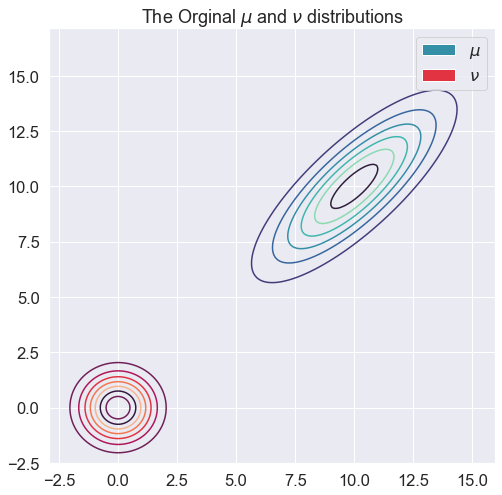

In [8]:
import numpy.linalg as npl
fig, axis = plt.subplots()
plot_2d_gaussian(X, scatter=False, axis=axis, color=mako, mean=mu_mean, cov=mu_cov)
plot_2d_gaussian(Y, scatter=False, axis=axis, color=rocket, mean=V_mean, cov=V_cov)


proxy = [plt.Rectangle((0,0),1,1,fc = color) 
    for color in [mako[3], rocket[3]]]
plt.title(r'The Orginal $\mu$ and $\nu$ distributions')
plt.legend(proxy, [r'$\mu$', r'$\nu$'])
plt.show()

## McCann Interpolates

Let  $T_\#\pi^{(0)} = \pi^{(1)}$ and $\lambda \in [0,1]$

Then the $W_2$ geodesic between $\pi^{(0)}$ and $\pi^{(1)}$ is:

$\pi^{(\lambda)} = [(1-\lambda)id + \lambda T]_\# \pi^{(0)}$

*i.e.* using $\lambda$ as are our interpolate, we can move smoothly from the transport being the idendity ($\lambda=0$) and the transport being the full $T$ ($\lambda=1$), and thus find $\pi^{(\lambda)}$s along this geodesic (straight line)

In [9]:
def mccan_interpolate(t, mu_mean, mu_cov, V_mean, V_cov):
    Zt_mean = (1-t)* mu_mean + t*V_mean
    sqrt_mu_cov = scipy.linalg.sqrtm(mu_cov)
    sqrt_mu_cov_i = npl.inv(scipy.linalg.sqrtm(mu_cov))
    sqrtm = scipy.linalg.sqrtm
    Zt_cov = sqrt_mu_cov_i @ npl.matrix_power( (1-t)*mu_cov + t*sqrtm(sqrt_mu_cov @ V_cov @ sqrt_mu_cov), 2) @ sqrt_mu_cov_i
    return Zt_mean, Zt_cov

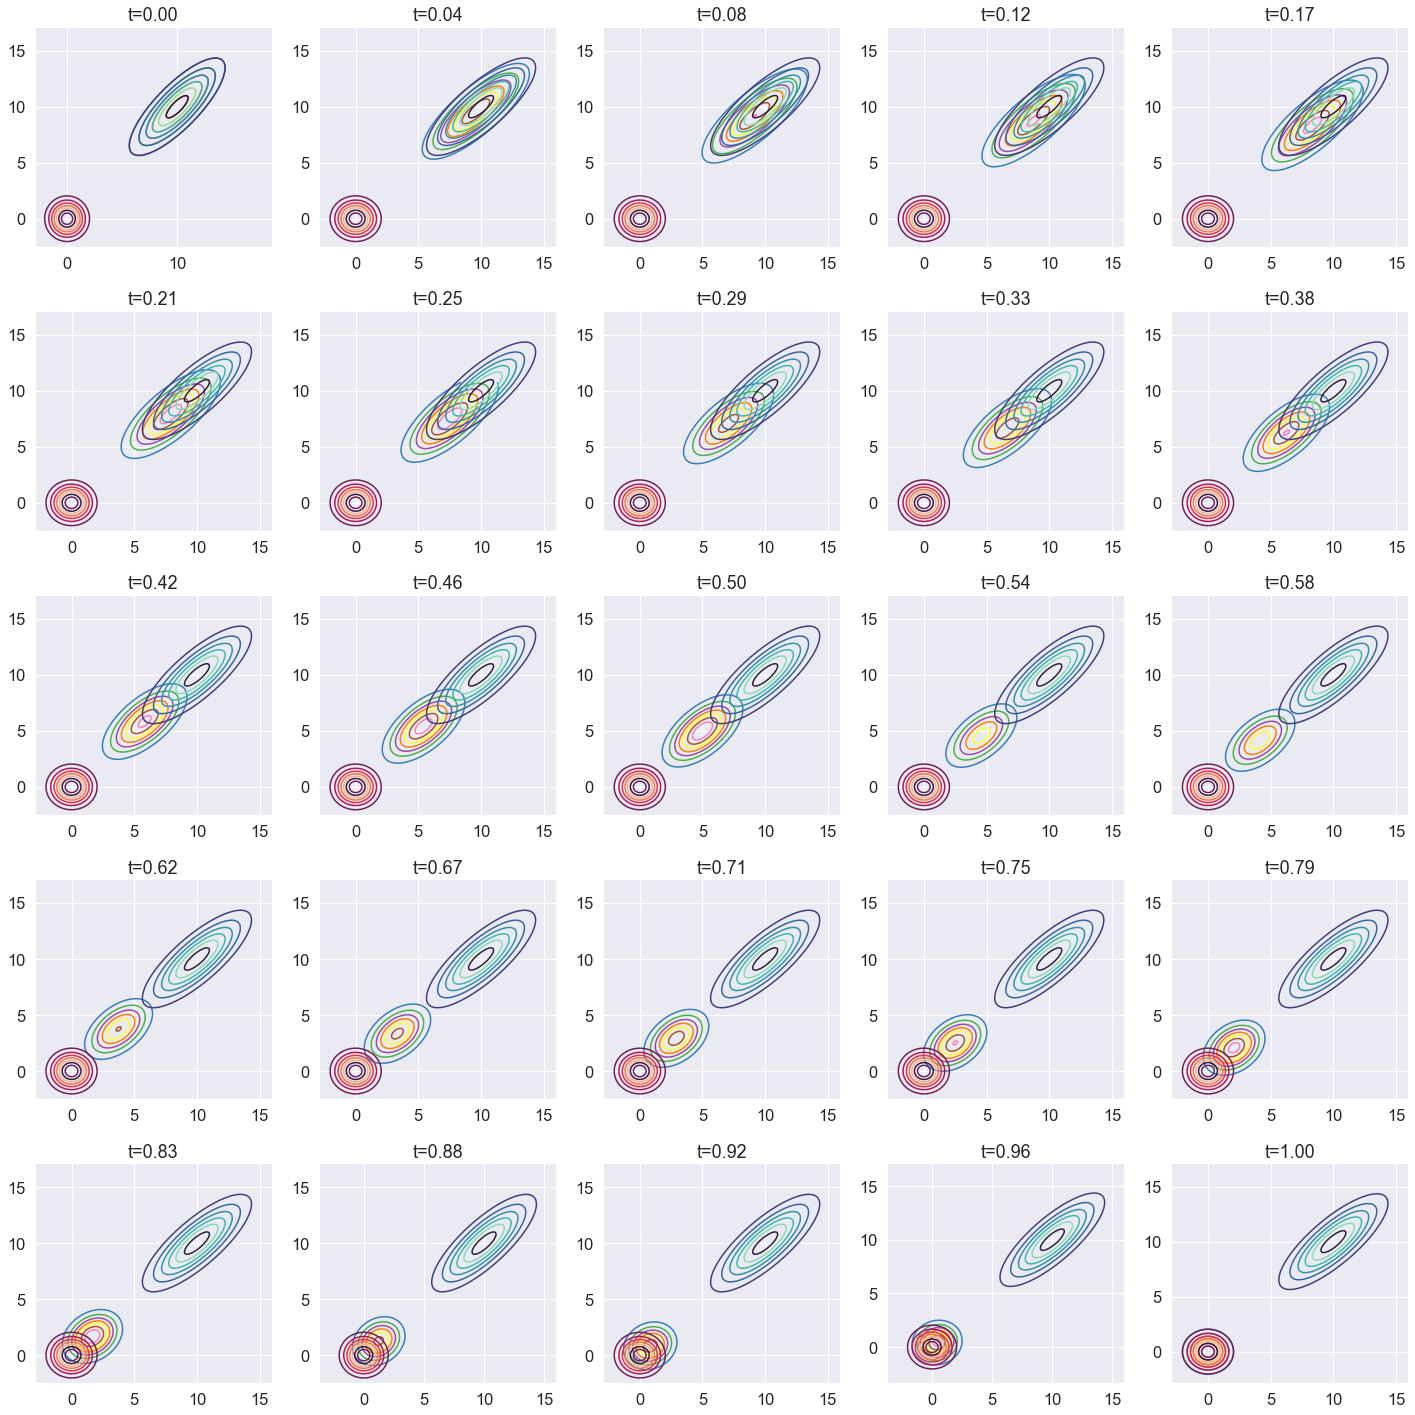

In [10]:
import numpy.linalg as npl
fig, axes = plt.subplots(5,5, figsize=(20,20))
# plot_2d_gaussian(X, scatter=False, axis=axes[0][0], color=mako, mean=mu_mean, cov=mu_cov)
# plot_2d_gaussian(Y, scatter=False, axis=axes[0][0], color=rocket, mean=V_mean, cov=V_cov)

t_arr = np.linspace(0, 1, 25)
for ax, t in zip(axes.flatten(), t_arr):
    Zt_mean, Zt_cov = mccan_interpolate(t, mu_mean, mu_cov, V_mean, V_cov)
    Zt = rng.multivariate_normal(Zt_mean, Zt_cov, size=n_samples)
    plot_2d_gaussian(Zt, scatter=False, axis=ax, color=pal, mean=Zt_mean, cov=Zt_cov)
    plot_2d_gaussian(X, scatter=False, axis=ax, color=mako, mean=mu_mean, cov=mu_cov)
    plot_2d_gaussian(Y, scatter=False, axis=ax, color=rocket, mean=V_mean, cov=V_cov)
    ax.set_title(f't={t:.2f}')

plt.tight_layout()
plt.show()

In [11]:
X_pushed = gaussian_push_forward(X, mu_mean, mu_cov, V_mean, V_cov)
distance_between_X_pushed_and_V = gaussain_wasserstein_2_2(np.mean(X_pushed, axis=0), np.cov(X_pushed, rowvar=False),
                                                           V_mean, V_cov)

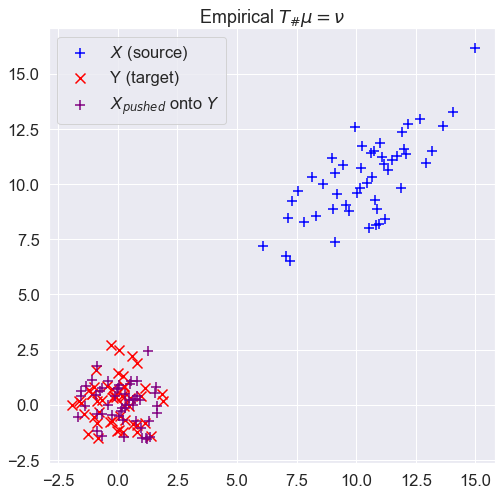

In [12]:
fig, axis = plt.subplots()
plot_2d_gaussian(X, axis=axis, color='blue', marker='+', label=r'$X$ (source)')
plot_2d_gaussian(Y, axis=axis, color='red', marker='x', label=r'Y (target)')
plot_2d_gaussian(X_pushed, axis=axis, color='purple', marker='+', label=r'$X_{pushed}$ onto $Y$')
plt.legend()
plt.title(r'Empirical $T_\#\mu = \nu$')
plt.show()

In [13]:
print(f'Original squared Wasserstein_2 distance,: {gaussain_wasserstein_2_2(mu_mean, mu_cov, V_mean, V_cov)}')
print(f'Pushed-forward squared Wasserstein_2 distance: {distance_between_X_pushed_and_V:.3f}')

Original squared Wasserstein_2 distance,: 204.0
Pushed-forward squared Wasserstein_2 distance: 0.052


# Showing Sinkhorn with our Gaussian Using PyOT 

In [14]:
X_probs = scipy.stats.multivariate_normal(mean=mu_mean, cov=mu_cov).pdf(X)
a = X_probs / X_probs.sum()

Y_probs = scipy.stats.multivariate_normal(mean=V_mean, cov=V_cov).pdf(Y)
b = Y_probs / Y_probs.sum()

In [15]:
# intializing variables
# a, b = np.ones((n_samples)) / n_samples, np.ones((n_samples)) / n_samples  # uniform distribution on samples
# loss matrix
M = ot.dist(X, Y)  # computes the distance matrix for us :)
M /= M.max()

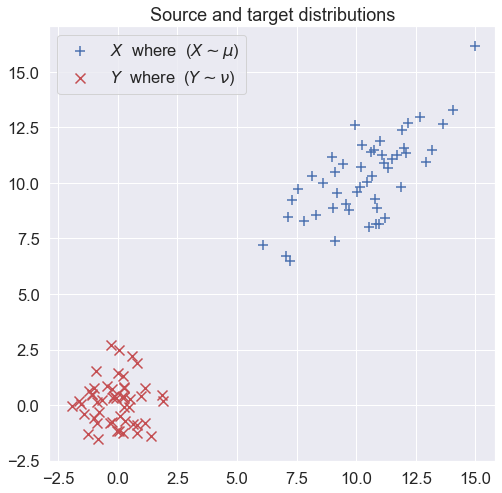

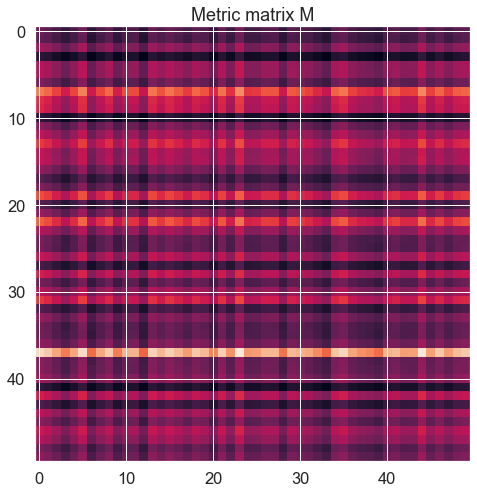

In [16]:
plt.figure(1)
plt.scatter(*X.T, marker='+', s=100, label=r'$X$  where  ($X \sim \mu$)', c='b')
plt.scatter(*Y.T, marker='x', s=100, label=r'$Y$  where  ($Y \sim \nu$)', c='r')
plt.legend(loc=0)
plt.title('Source and target distributions')

plt.figure(2)
plt.imshow(M, interpolation='nearest')
plt.title('Metric matrix M')
plt.show()

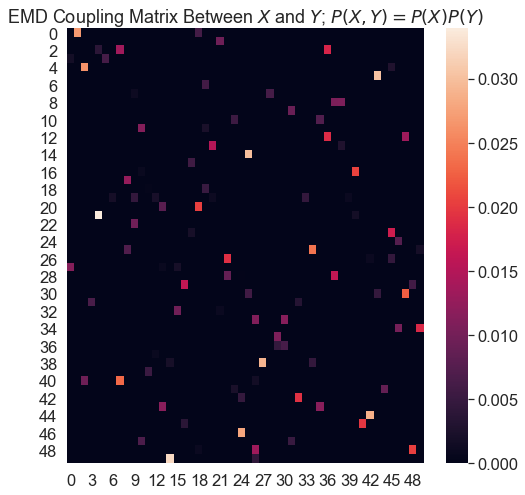

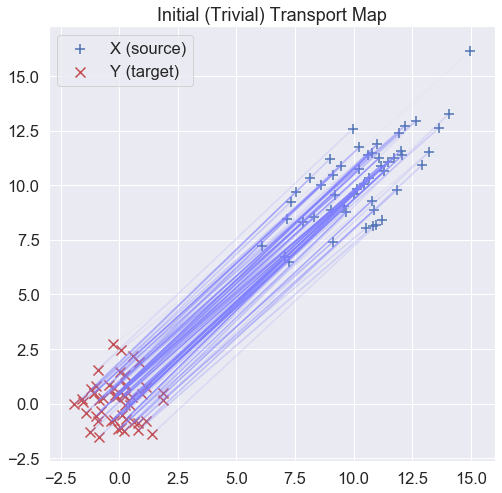

In [17]:
P_emd = ot.emd(a, b, M)

plt.figure(3)
sn.heatmap(P_emd)
plt.title(r'EMD Coupling Matrix Between $X$ and $Y$; $P(X, Y) = P(X)P(Y)$')

plt.figure(4)
ot.plot.plot2D_samples_mat(X, Y, P_emd, color=[.5, .5, 1])
plt.scatter(*X.T, marker='+', s=100, label='X (source)', c='b')
plt.scatter(*Y.T, marker='x', s=100, label=r'Y (target)', c='r')
plt.legend(loc=0)
plt.title('Initial (Trivial) Transport Map')
plt.show()

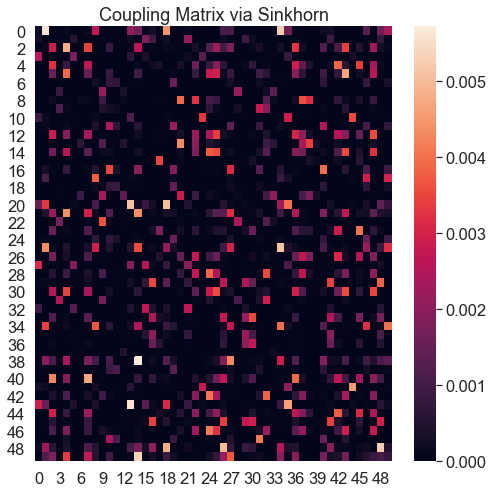

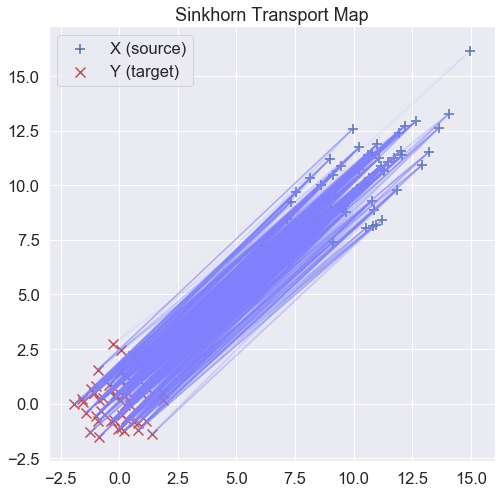

In [18]:
# reg term
lambd = 1e-3

P_sinkhorn = ot.sinkhorn(a, b, M, lambd)

plt.figure(5)
sn.heatmap(P_sinkhorn)
plt.title('Coupling Matrix via Sinkhorn')

plt.figure(6)
ot.plot.plot2D_samples_mat(X, Y, P_sinkhorn, color=[.5, .5, 1])
plt.scatter(*X.T, marker='+', s=100, label='X (source)', c='b')
plt.scatter(*Y.T, marker='x', s=100, label=r'Y (target)', c='r')
plt.legend(loc=0)
plt.title('Sinkhorn Transport Map')
plt.show()